#Cube Solver

This project allows you to input images of the faces of a cube and prints out an algorithm to solve it. 

It uses Segmentation to detect the actual faces of the cube and then assumes a uniform 3*3 grid-like distribution to find the color of each piece.

The logic used to assign colors is at: [line 28](https://colab.research.google.com/drive/1YyI__JZdwIeeSkUspFp_6xCb1ja0HgsA#scrollTo=5Wu-x2IlM5cV&line=28&uniqifier=1). Current logic: Find closest color from a set of 6 predefined colors (Logic needs to be changed with different cubes). I am working on clustering algorithms to solve this issue.

Once the colors are detected, it is converted into a format according to [Kociemba Solver](https://colab.research.google.com/drive/1YyI__JZdwIeeSkUspFp_6xCb1ja0HgsA#scrollTo=5Wu-x2IlM5cV&line=28&uniqifier=1), and then solved by the Kociemba algorithm, which allows any configuration to be solved in less than 30 steps.

The final output is an algorithm to solve the cube (and the number of steps).



---


## Instructions of use

1. Upload the model weights file in your google drive and put its path [here](https://colab.research.google.com/drive/1YyI__JZdwIeeSkUspFp_6xCb1ja0HgsA#scrollTo=6LqqPSGQSGXJ&line=1&uniqifier=1) 

2.   Run the following cells in order upto the section 'Main Inference'. They have requirements and helper functions.
3.   Readying inputs:
    
    a. take images of each face of the cube such that the image in the below figure would look straight.
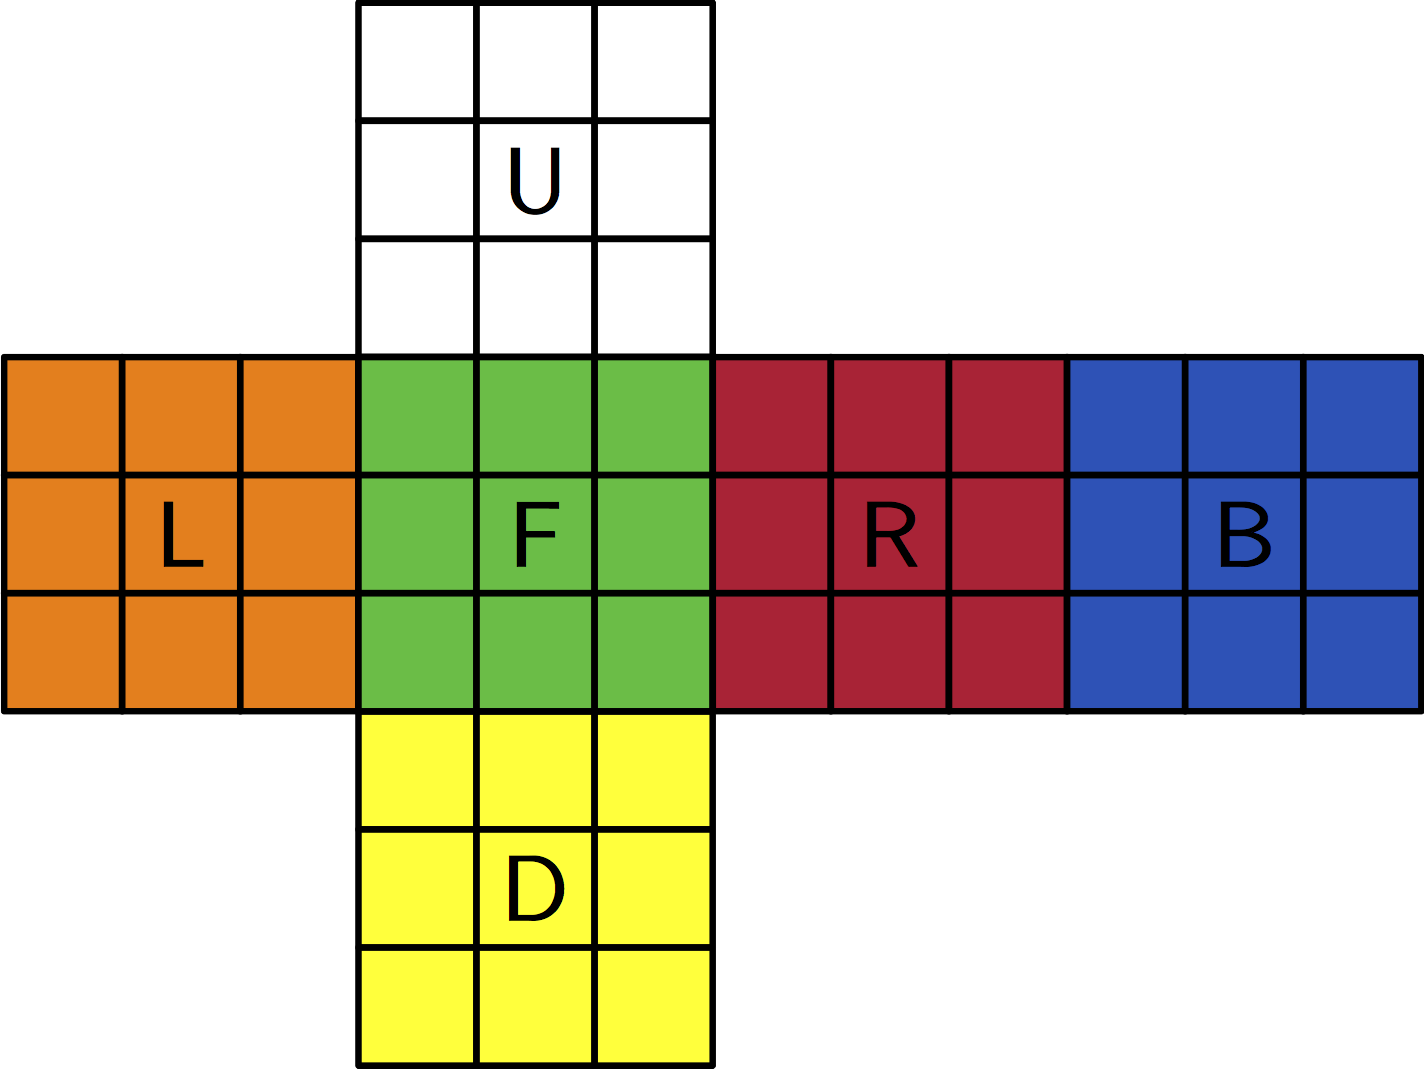
    b. make a directory '/content/scramble/' and add the files in the format 'cube<i>.png' (This format can be changed by changing the final inference function.)
4. run the final inference function to get the algorithms to solve the cube.
The algorithm consists of a list of characters that follow [this convention](https://ruwix.com/the-rubiks-cube/notation/).




#Installing requirements

This cell allows colab to connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


This cell copies the model codes and other requirements for Mask-RCNN stored in google drive.
 
The github repo for Mask-RCNN is at: https://github.com/matterport/Mask_RCNN

In [ ]:
!pip install pycuber
!pip install rubik-solver
!pip install kociemba
# !sudo cp -avr /content/drive/My\ Drive/cube\ solver/Mask_RCNN /root/
%cd ~/
!git clone https://github.com/matterport/Mask_RCNN.git

%tensorflow_version 1.x
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

%cd ~/Mask_RCNN/
!sed -i -- 's/tensorflow>=1.3.0/tensorflow==1.15.2/g' requirements.txt
!sed -i -- 's/keras>=2.0.8/keras==2.1.0/g' requirements.txt

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

import cv2 as cv

from IPython.display import clear_output
clear_output()

#Top face Segmentation Model (Loading Weights)

This code copies the weights of our trained models in the colab runtime. The weights are stored in Google Drive. The weights are then loaded and a model is initialised

In [ ]:
!cp /content/drive/My\ Drive/cube\ solver/models/50/mask_rcnn_cube_face_0070.h5 /root/Mask_RCNN/top_face_seg.h5

In [ ]:
#important!!
#if using extra conv layers for mask models, use mrcnn_conv in place of mrcnn
%cd ~/Mask_RCNN
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import time


class_names = ['BG', 'cube face']

# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 1
     DETECTION_MIN_CONFIDENCE = 0.7

# define the model
rcnn_top_face = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
# rcnn.load_weights(<weights_path>, by_name=True)

rcnn_top_face.load_weights('/root/Mask_RCNN/top_face_seg.h5', by_name=True)
#rcnn_box.keras_model.summary()

from IPython.display import clear_output
clear_output()

#Segmentation Inference codes 

This cell has some helper functions that are used in the main Segmentation function later on. These have been taken directly from the visualise.py file of the Mask RCNN implementation

In [ ]:
import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


#
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


This cell has the main inference functions of segmentation. These have been taken from the visualise.py file of Mask-RCNN repo with some modifications added to get:

1) Separate masks (in case of top face segmentation)

2) Masks on top of original images with scores and bounding boxes (in case of box segmentation)

In [ ]:

##My modifications are in the functions below

#function for storing separate masks
def display_instances(mask_path, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    masked_image = image.astype(np.uint32).copy()

   
    
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]

        # Mask
        
         #only mask will be a black image with masks
        only_mask = np.zeros(masked_image.shape)


        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
            only_mask = apply_mask(only_mask, mask, color)
            only_mask = np.float32(only_mask)
            only_mask = cv2.cvtColor(only_mask, cv2.COLOR_BGR2RGB)
            cv2.imwrite(mask_path + str(i+1) + '.jpg', only_mask)
        
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)

    return masked_image.astype(np.uint8), N


def save_results_top_face(img_path, save_path, mask_path):

  img = load_img(img_path)
  img = img_to_array(img)
  # make prediction
  results = rcnn_top_face.detect([img], verbose=0)
  # get dictionary for first prediction
  r = results[0]

  res, no_of_stacks = display_instances(mask_path, img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  cv2.imwrite(save_path, res)
  time.sleep(1)
  return no_of_stacks



  
    


#functioon for storing output with scores
def display_instances_one_mask(save_path, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()

   
    only_mask = np.zeros(masked_image.shape)
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        
         #only mask will be a black image with masks
        


        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
            only_mask = apply_mask(only_mask, mask, color)
            
            
            
        
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    only_mask = np.float32(only_mask)
    only_mask = cv2.cvtColor(only_mask, cv2.COLOR_BGR2RGB)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig(save_path)
    plt.close('all')

    return masked_image.astype(np.uint8), N


import cv2
def save_results_boxes(img_path, save_path = '/root/Mask_RCNN/result.jpg', visualize = True):
  img = load_img(img_path)
  img = img_to_array(img)
  results = rcnn_box.detect([img], verbose=0)
  r = results[0]

  res, n = display_instances_one_mask(save_path, img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  if visualize:
      print('Box seg-counting done')
  boxes = r['rois']
  boxes_to_pts_counter = 1
  pts = []
  box = boxes[0]
  pts.append([[box[1], box[0]], [box[3], box[2]]])
  while boxes_to_pts_counter < boxes.shape[0]:
    if r['scores'][boxes_to_pts_counter]>0.9:
        box = boxes[boxes_to_pts_counter]
        pts.append([[box[1], box[0]], [box[3], box[2]]])
    boxes_to_pts_counter +=1
  n = template_match_thres_decay(img_path, pts, save_path)
  if visualize:
      print('Box template-counting done')
  #cv2.imwrite(save_path, res)
  time.sleep(1)
  return n
    



#Flat Extraction code

This part allows us to convert the top surfaces into the front facing view (from any initial view) from the masks obtained in Top Face Segmentation.

We use [Perspective Transform](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html) to get front view. We use Approx Polygon to find quadrilateral from masks. 

In [ ]:
import math
import cv2
import scipy.spatial.distance
from scipy.spatial import distance as dist
import numpy as np





def order_points(pts, img):
    return np.asarray([pts[0], pts[1], pts[3], pts[2]], dtype=pts.dtype)

def get_perspective1(img_path, corners, save_path):
    
    img = cv2.imread(img_path)
    points = order_points(corners, img)
    #print(points)
    pts1 = np.float32([points[0],points[1],points[2],points[3]])
    W = 1024
    H = 1024
    pts2 = np.float32([[0,0],[W,0],[0,H],[W,H]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgOutput = cv2.warpPerspective(img,matrix,(W,H), flags=cv2.INTER_NEAREST)
    if W>1.5 * H:
        imgOutput = cv2.rotate(imgOutput, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(save_path, imgOutput)


def get_perspective(img_path, corners, save_path):
    width = 1024
    height = 1024
    img = cv2.imread(img_path)
    #print(img.shape)
    #img = cv2.resize(img, (1422, 800)) 
    #print(img.shape)
    [x_mean, y_mean] = np.mean(corners, axis = 0)
    #y_mean = 800 - y_mean
    #[x_max, y_max] = np.maximum(corners, axis = 0)
    #[x_min, y_min] = np.minimum(corners, axis = 0)
    new_corners = np.zeros((4,2),np.int)
    i = 0
    while i<4:
        [x, y] = corners[i]
        #y = 800 - y
        if x<=x_mean and y<=y_mean:
            new_corners[0] = [x, y]
            #print(x, y)
        elif x>x_mean and y<=y_mean:
            new_corners[1] = [x, y]
            #print(x, y)
        elif x<=x_mean and y>y_mean:
            new_corners[2] = [x, y]
            #print(x, y)
        elif x>x_mean and y>y_mean:
            new_corners[3] = [x, y]
            #print(x, y)
        i = i+1
    points = new_corners
    pts1 = np.float32([points[0],points[1],points[2],points[3]])
    pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgOutput = cv2.warpPerspective(img,matrix,(width,height), flags=cv2.INTER_NEAREST)
    cv2.imwrite(save_path, imgOutput)
    

##Auto contrast Code

def automatic_brightness_and_contrast(image, clip_hist_percent=2):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha


    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


def auto_cont(img_path, save_path):
    image = cv2.imread(img_path)
    auto_result, alpha, beta = automatic_brightness_and_contrast(image)
    cv2.imwrite(save_path, auto_result)
    



#main flat extractor code
def flat_extractor(input_image_path, mask_path, save_path):
    original = cv2.imread(input_image_path)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY )
    ret,mask = cv.threshold(mask,10,255,cv.THRESH_BINARY)
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR )
    (cnts, _) = cv2.findContours(mask.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)
    is_flat = False
    for c in cnts:
        peri = cv2.arcLength(c, True)
        acc = 0.001
        for i in range(100):
            approx = cv2.approxPolyDP(c, i * acc * peri, True)
            if len(approx)==4:
                break 
        

        if len(approx) == 4 and cv2.arcLength(approx,True) > 100:
            #print(approx)
            is_flat = True
            cv2.drawContours(mask_color, [approx], -1, (0,255,0), 3)
            cv2.drawContours(original, [approx], -1, (0,255,0), 3)
            get_perspective(input_image_path, approx[:, 0, :],save_path)
            #auto_cont(save_path, save_path)
    return is_flat


        


#pyCube converter

In [ ]:
from rubik_solver import utils
import pycuber as pc
from pycuber.solver import CFOPSolver
from io import StringIO 
import sys
from scipy.spatial import distance as dist

cube_colors = [[255, 255, 255], [0, 255, 255], [255, 0, 0], [1, 255, 0], [0, 0, 225], [255, 255, 0]]
cube_colors_names = ['white', 'yellow', 'blue', 'green', 'red', 'orange']
color_map = {'white': 0, 'yellow': 1, 'blue': 3, 'green': 2, 'red': 4, 'orange': 5}
#color_map = {'white': 5, 'yellow': 0, 'blue': 4, 'green': 2, 'red': 1, 'orange': 3}
color_map_inv = {v: k for k, v in color_map.items()}
color_map_rubik = {'white': 'w', 'yellow': 'y', 'blue': 'b', 'green': 'g', 'red': 'r', 'orange': 'o'}


def get_colors(img):
    h, w = img.shape[0:2]
    colors = []
    i = 0
    while i < 9:
        #print(i)
        color = img[(h//3) * (i//3) + h//6, (w//3) * (i%3) + w//6]
        colors.append(color)
        i = i+1
    #print(colors)
    return colors

def get_cube_color(color):

    
    #if (color[0]>200 and color[1]>200 and color[2]>200):
    #    return cube_colors_names[0]
    #elif (color[0]<50 and color[1]>220 and color[2]>200):
    #    return cube_colors_names[1]
    #elif (color[0]>200 and color[1]<50 and color[2]<50):
    #    return cube_colors_names[2]
    #elif (color[0]<50 and color[1]>100 and color[2]<50):
    #    return cube_colors_names[3]
    #elif (color[0]<50 and color[1]<50 and color[2]>200):
    #    return cube_colors_names[4]
    #elif (color[0]>200 and color[1]>200 and color[2]<50):
    #    return cube_colors_names[5]
    #else:
    #    return cube_colors_names[2]
    dist_min = 10000
    j = 0
    for i in range(6):
        
        distanc = dist.euclidean(cube_colors[i], color)
        #np.sum(np.square(color - cube_colors[i]))
        if distanc < dist_min:
            j = i
            dist_min = distanc
            #print(dist)

    return cube_colors_names[j]

def get_cube_rubik(cube_flat):
    s= color_map_rubik[color_map_inv[cube_flat[0]]]
    i = 1
    while i < len(cube_flat):
        s= s + color_map_rubik[color_map_inv[cube_flat[i]]]
        i=i+1
    return s


def get_matrix(colors):

    matrix = []
    i = 0
    print(colors)
    while i <9:
        matrix.append(get_cube_color(colors[i]))
        i = i+1
    #print(matrix)
    return matrix


def add_matrix(matrix, cube_flat):
    center_color =  matrix[4]
    #no = center_color
    matrix_no = np.zeros(9)
    for i in range(9):
        matrix_no[i] = color_map[matrix[i]]

    no = color_map[center_color]
    cube_flat[9*no:9*no+9] = matrix_no
    return cube_flat


def combine_cube(cube_flat):
    cube = pc.Cube()
    sides = [cube.D, cube.U, cube.F, cube.B, cube.L, cube.R]
    counter = 0 
    for x in sides:
        for i in range(3):
            for j in range(3):
                #print(x[i][j].colour)
                #print(type(x[i][j]))
                x[i][j] = Square(color_map_inv[cube_flat[counter]]) #color_map_rubik[color_map_inv[cube_flat[counter]]]
                counter+=1
                #print(counter, x[i][j], color_map_inv[cube_flat[counter-1]])
    #print(cube)
    return cube

def get_list(img_format):
    img_list = []
    for i in range(1000):
        img_path  = img_format + str(i+1) + '.jpg'
        img = cv2.imread(img_path)
        if isinstance(img, np.ndarray):
            img_list.append(img)
    return(img_list)



In [ ]:
def cube_encode(img_list):
    i = 0
    cube_flat = np.zeros(54)
    while i < len(img_list):
        colors = get_colors(img_list[i])
        matrix = get_matrix(colors)
        add_matrix(matrix, cube_flat)
        i = i+1
    print(cube_flat)
    cube = combine_cube(cube_flat)
    return cube

#Kociemba solver

Efficient algorithm that solves any cube in upto 30 steps. This uses Group theory and DFS-type searching algorithms

https://www.speedsolving.com/wiki/index.php/Kociemba%27s_Algorithm

[wikipedia](https://en.wikipedia.org/wiki/Optimal_solutions_for_Rubik%27s_Cube)

In [ ]:
import kociemba
from rubik_solver import utils
from io import StringIO 
import sys
from scipy.spatial import distance as dist

cube_colors = [[255, 255, 255], [0, 255, 255], [255, 0, 0], [1, 255, 0], [0, 0, 225], [0, 125, 255]]
cube_colors_names = ['white', 'yellow', 'blue', 'green', 'red', 'orange']
#color_map = {'white': 0, 'yellow': 1, 'blue': 3, 'green': 2, 'red': 4, 'orange': 5}
color_map = {'white': 3, 'yellow': 0, 'blue': 5, 'green': 2, 'red': 4, 'orange': 1}
color_map_inv = {v: k for k, v in color_map.items()}
color_map_rubik = {'white': 'w', 'yellow': 'y', 'blue': 'b', 'green': 'g', 'red': 'r', 'orange': 'o'}
kociemba_map = {'white': 'D', 'yellow': 'U', 'blue': 'B', 'green': 'F', 'red': 'L', 'orange': 'R'}

def get_colors(img):
    h, w = img.shape[0:2]
    colors = []
    i = 0
    while i < 9:
        #print(i)
        color = img[(h//3) * (i//3) + h//6, (w//3) * (i%3) + w//6]
        colors.append(color)
        i = i+1
    #print(colors)
    return colors


def get_cube_color(color):
    dist_min = 10000
    j = 0
    for i in range(6):
        
        distanc = dist.euclidean(cube_colors[i], color)
        #np.sum(np.square(color - cube_colors[i]))
        if distanc < dist_min:
            j = i
            dist_min = distanc
            #print(dist)

    return cube_colors_names[j]

def get_matrix(colors):

    matrix = []
    i = 0
    #print(colors)
    while i <9:
        matrix.append(get_cube_color(colors[i]))
        i = i+1
    #print(matrix)
    return matrix

def add_matrix(matrix, cube_flat):
    center_color =  matrix[4]
    #no = center_color
    matrix_no = np.zeros(9)
    for i in range(9):
        matrix_no[i] = color_map[matrix[i]]

    no = color_map[center_color]
    cube_flat[9*no:9*no+9] = matrix_no
    return cube_flat


def get_cube_kociemba(cube_flat):
    s= kociemba_map[color_map_inv[cube_flat[0]]]
    i = 1
    while i < len(cube_flat):
        s= s + kociemba_map[color_map_inv[cube_flat[i]]]
        i=i+1
    return s

In [ ]:
def cube_encode(img_list):
    i = 0
    cube_flat = np.zeros(54)
    while i < len(img_list):
        colors = get_colors(img_list[i])
        matrix = get_matrix(colors)
        add_matrix(matrix, cube_flat)
        i = i+1
    #print(cube_flat)
    cube = get_cube_kociemba(cube_flat)
    return cube

#Final Inference Function

In [ ]:
def cube_solver(img_format, visualise = True):
    no_of_boxes = []
    img_list = []
    if visualise:
        print('The Cube is being converted...')
    for i in range(1000):
        mask_path = '/root/Mask_RCNN/mask'
        #no_of_stacks = save_results_top_face(input_image_path, 'result.jpg', mask_path)

        img_path  = img_format + str(i+1) + '.jpg'
        img = cv2.imread(img_path)
        if isinstance(img, np.ndarray):
            
            flat_save_path = '/root/Mask_RCNN/flat' + str(i+1) + '.jpg'
            curent_mask_path = mask_path + str(1) + '.jpg'
            no_of_stacks = save_results_top_face(img_path, 'result.jpg', mask_path)
            is_flat = flat_extractor(img_path, curent_mask_path, flat_save_path)
            if visualise:
                if not is_flat:
                    no_of_boxes.append(0)
                    print('Face not detected!!!')
                    print('==========')
                    i = i+1
                    continue
                else:
                    print('Face detected!')
            img = cv2.imread(flat_save_path)
            img_list.append(img)
    cube = cube_encode(img_list)
    #print(cube)
    if visualise:
        print('The cube is being solved...')
    print('The algorithm to solve the cube is: ')
    algo = kociemba.solve(cube)
    print(algo)
    steps = 1
    for s in algo:
        if s==' ':
            steps += 1
    print('No. of steps: ', steps)
    #print(cube('F'))
    #solver = CFOPSolver(cube)
    #
    #utils.solve(cube, 'CFOP')
    #with Capturing() as output:
    #    solver.solve()
    #print('Solved!')
    #print('The steps you need to solve the cube are: \n \n' + (output[-1][6:]))



###Preprocessing

In [ ]:
for i in range(6):
#if True:        
#        i = 2
        img_format = '/content/scramble/cube'
        img_path  = img_format + str(i+1) + '.jpg'
        img = cv2.imread(img_path)
        im_crop = img[650:1800, :]
        cv2.imwrite(img_path, im_crop)

#Main Inference

In [ ]:
cube_solver('/content/scramble/cube')

The Cube is being converted...
Face detected!
Face detected!
Face detected!
Face detected!
Face detected!
Face detected!
The cube is being solved...
The algorithm to solve the cube is: 
R2 U F B2 R D L' U F' R' B' U R2 F2 L2 U R2 D B2 R2 F2


In [ ]:
#cube = pc.Cube()
print(cube)

my_formula = pc.Formula("B U D B' R2 U' B' U B U' R U R' B U B' U2 B U2 B' U R' U' R L U L' U' L U L' U L' U' L U L' U2 L U' F' U' F' L F L' U F U2 F2 B2 D F2 B2 U F' B L2 F2 B2 R2 F' B U2 B U D B' R2 U' B' U B U' R U R' B U B' U2 B U2 B' U R' U' R L U L' U' L U L' U L' U' L U L' U2 L U' F' U' F' L F L' U F U2 F2 B2 D F2 B2 U F' B L2 F2 B2 R2 F' B U2")
cube(my_formula)
#cube(my_formula)
#cube(my_formula)
#cube(my_formula)
#cube(my_formula)
#cube(my_formula)
#solver = CFOPSolver(cube)
#solver.solve()

         [y][y][y]
         [y][y][y]
         [y][y][y]
[b][b][b][r][r][r][g][g][g][o][o][o]
[b][b][b][r][r][r][g][g][g][o][o][o]
[b][b][b][r][r][r][g][g][g][o][o][o]
         [w][w][w]
         [w][w][w]
         [w][w][w]



In [ ]:
my_formula = pc.Formula("B U D B' R2 U' B' U B U' R U R' B U B' U2 B U2 B' U R' U' R L U L' U' L U L' U L' U' L U L' U2 L U' F' U' F' L F L' U F U2 F2 B2 D F2 B2 U F' B L2 F2 B2 R2 F' B U2 B U D B' R2 U' B' U B U' R U R' B U B' U2 B U2 B' U R' U' R L U L' U' L U L' U L' U' L U L' U2 L U' F' U' F' L F L' U F U2 F2 B2 D F2 B2 U F' B L2 F2 B2 R2 F' B U2")
cube1 = cube(my_formula).copy()
print(cube(my_formula))
solver = CFOPSolver(cube)
alg = solver.solve()
cube
print(cube1)
alg = "D' B D' B' D2 U R U' R' U2 R U' R' U F U2 F' U' B' U' B F U' F' L' U2 L U' F' L F R' F' L' F R U L U L' B' L U L' U' L' B L2 U' L' U'"
 
cube1(alg)

         [b][y][o]
         [w][y][r]
         [r][b][w]
[o][b][y][b][y][r][b][b][y][g][o][y]
[w][b][b][o][r][w][g][g][r][g][o][r]
[w][y][g][w][y][g][r][o][o][w][o][b]
         [r][r][y]
         [g][w][g]
         [o][w][g]

Cross: R' U2 D2 R2 B D2
F2L('red', 'green'): F' U' F
F2L('green', 'orange'): y R U R' F' U' F
F2L('orange', 'blue'): y2 R U R' y' F' U F
F2L('blue', 'red'): y U F' U2 F U F' U' F
OLL:  U2 R U R' U R d' R U' R' F'
PLL:  y M2 U M2 U M' U2 M2 U2 M' U2

FULL: R' U2 D2 R2 B D2 F' U' F B U B' R' U' R F U F' B' U B U L' U2 L U L' U' L U2 F U F' U F U' R U' R' F B2 D B2 F2 U B' F R2 B2 F2 L2 B' F U2
         [o][y][g]
         [g][y][o]
         [b][b][r]
[y][y][r][y][w][w][g][b][o][y][o][b]
[r][b][w][r][r][g][o][g][w][g][o][y]
[o][r][r][y][b][b][r][g][w][g][o][w]
         [g][y][w]
         [b][w][r]
         [b][w][o]

